<h3> Simulación de pocos fotones de la NLSE </h3>
El objetivo es simular el circuito completo de generacion y detección de pares de fotones heraldos utilizando componentes reales

Para eso necesitaremos una ampliación del modelo de NLSE para régimen cuántico

0 de 10
1 de 10
2 de 10
3 de 10
4 de 10
5 de 10
6 de 10
7 de 10
8 de 10
9 de 10


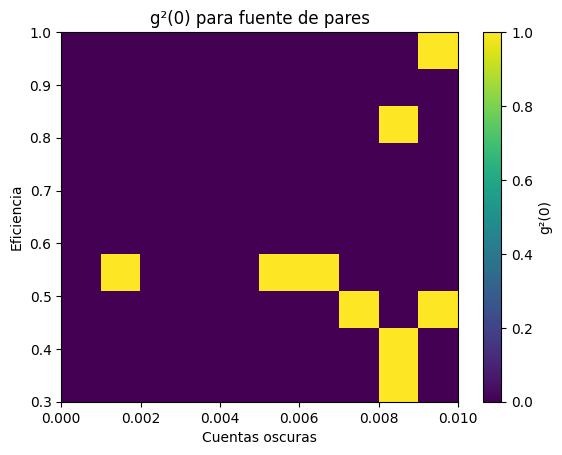

0.0


In [8]:
import cupy as cp
import matplotlib.pyplot as plt
import numpy as np
from Dispositivos import BeamSplitter, Filtro, APD, coincidencias_temporales, coincidencias_dobles_y_triples

# Parámetros de simulación
#Cuanto dura un bin?? 1ms
timestep = 1 #ns
Bins = 50000
DuracionTotal = Bins*timestep
Average_Pairs_Per_Bin = 0.01  # Ahora puede haber más de un par por bin
ventana = 1


VecFotones = []

# Generación de fotones (solo pares)
for _ in range(Bins):
    num_pairs = cp.random.poisson(Average_Pairs_Per_Bin).item()
    if num_pairs > 0:
        tiempos = cp.random.randint(1,DuracionTotal, size=num_pairs)
        tiempos = cp.repeat(tiempos, 2)
        longitudes = cp.tile(cp.array([100, 300]), num_pairs)
        VecFotones.append(cp.column_stack((tiempos, longitudes)))

# Paso a device
VecFotones = cp.concatenate(VecFotones, axis=0) if VecFotones else cp.empty((0, 2), dtype=int)

# Rangos
eficiencias = cp.linspace(1, 0.3, 10)
osc = cp.linspace(0,0.01,10)

# Inicialización de resultados
N12 = cp.zeros((len(eficiencias), len(osc)), dtype=int)
N13 = cp.zeros((len(eficiencias), len(osc)), dtype=int)
N123 = cp.zeros((len(eficiencias), len(osc)), dtype=int)
N1 = cp.zeros((len(eficiencias), len(osc)), dtype=int)
g2 = cp.ones((len(eficiencias), len(osc)))

# Dispositivos
BS = BeamSplitter(0.5)
FiltroS = Filtro(F1=50, F2=200)
FiltroI = Filtro(F1=150, F2=300)

# Simulación
for eff_idx, eff in enumerate(eficiencias):
    print(eff_idx, "de", len(eficiencias))
    for k_idx, k in enumerate(osc):
        dark = k
        detector = APD(eff, dark)

        # Primer divisor
        a, b = BS.Dividir(VecFotones)

        # Filtros
        camino1 = FiltroS.Filtrar(a)
        camino2 = FiltroI.Filtrar(b)

        # Segundo divisor (solo a camino2)
        c, d = BS.Dividir(camino2)

        # Detección
        t1 = detector.Detectar(camino1, DuracionTotal)
        t2 = detector.Detectar(c, DuracionTotal)
        t3 = detector.Detectar(d, DuracionTotal)

        # Coincidencias
        N12[eff_idx, k_idx], N13[eff_idx, k_idx], N123[eff_idx, k_idx] = cp.array(
            coincidencias_dobles_y_triples(t1, t2, t3, ventana)
        )

        # N1 como número de tiempos únicos de detección en APD1
        N1[eff_idx, k_idx] = cp.unique(t1).size

        # g2
        valid = (N12[eff_idx, k_idx] > 0) & (N13[eff_idx, k_idx] > 0)
        g2[eff_idx, k_idx] = cp.where(
            valid,
            N1[eff_idx, k_idx] * N123[eff_idx, k_idx] / (N12[eff_idx, k_idx] * N13[eff_idx, k_idx]),
            0
        )
    

# Paso a host
eficiencias = cp.asnumpy(eficiencias)
osc = cp.asnumpy(osc)
g2 = cp.asnumpy(g2)

# Gráfico
plt.imshow(g2, aspect='auto', cmap='viridis', origin='lower',
           extent=[osc[0], osc[-1], eficiencias[-1], eficiencias[0]])
plt.colorbar(label="g²(0)")
plt.xlabel("Cuentas oscuras")
plt.ylabel("Eficiencia")
plt.clim(0, 1)
plt.title("g²(0) para fuente de pares")
plt.show()

print(np.min(g2))

In [ ]:
print("Eficiencia: ",eficiencias)
print("N12",N12)
print("N13", N13)
#print("Bunch: ",Bunch)
print("N123: ",N123)
print("N1: ",N1)
print("g2: ",g2)

Eficiencia:  [1.         0.92222222 0.84444444 0.76666667 0.68888889 0.61111111
 0.53333333 0.45555556 0.37777778 0.3       ]
N12 [[ 0  1  1  7  1  2  8  3 11 11]
 [ 0  0  2  5  5  4  8  5 12 12]
 [ 0  0  4  4  3  3  7  9  8 11]
 [ 0  1  0  2  1  8  6 10 14  9]
 [ 0  0  1  2  2  7  4  7  9 20]
 [ 0  0  4  2  2  9 10  9  8 11]
 [ 0  0  3  0  3  3  6  9  9 16]
 [ 0  0  0  1  4  4  3  4 13 15]
 [ 0  0  1  0  4  4  7  7 16 12]
 [ 0  1  2  1  3  5  5 14 15 19]]
N13 [[ 0  0  1  2  5  2  8  4 15 17]
 [ 0  0  1  3  1  3  6  9 12 23]
 [ 0  0  0  3  4  7  0 12  7 15]
 [ 0  1  1  1  2  7  8 12 14 13]
 [ 0  0  0  3  1  5  5 10  9 16]
 [ 0  2  1  1  3  7  7 11 15 13]
 [ 0  0  0  2  0  4  4 11 14 16]
 [ 0  0  1  1  2  2  8  9 13 14]
 [ 0  0  0  1  5  3 10  8 13  9]
 [ 0  0  1  3  4  1  3  9 13 14]]
N123:  [[0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 1 0 1]
 [0 1 0 0 0 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0

: 

In [ ]:
print(g2)

[0.5        0.55414832 0.6290371  0.69805359 0.82955854 1.03655587
 1.28326    1.69587337]
